In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.python.keras import Input, Model
from tensorflow.python.keras.layers import Conv2D, DepthwiseConv2D, Add, BatchNormalization, ReLU, \
    GlobalAveragePooling2D, Dense

import tensorflow as tf
import numpy as np


def conv_block(input_layer,
               filters,
               kernel_size,
               apply_activation=True):
    output_layer = Conv2D(filters=filters,
                          kernel_size=kernel_size,
                          padding='same',
                          use_bias=False,
                          kernel_initializer='he_normal')(input_layer)
    output_layer = BatchNormalization()(output_layer)
    if not apply_activation:
        return output_layer
    return ReLU(max_value=6)(output_layer)


def linear_bottleneck(input_layer,
                      strides=(1, 1),
                      expand_filters=64,
                      squeeze_filters=16):
    output_layer = conv_block(input_layer, expand_filters, (3, 3))
    output_layer = DepthwiseConv2D(kernel_size=(3, 3),
                                   strides=strides,
                                   padding='same',
                                   use_bias=False,
                                   kernel_initializer='he_normal')(output_layer)
    output_layer = BatchNormalization()(output_layer)
    output_layer = ReLU(max_value=6)(output_layer)
    return conv_block(output_layer, squeeze_filters, (1, 1), apply_activation=False)


def inverted_linear_residual_block(input_layer,
                                   strides=(1, 1),
                                   expand_filters=64,
                                   squeeze_filters=16):
    output_layer = linear_bottleneck(input_layer,
                                     strides,
                                     expand_filters,
                                     squeeze_filters)
    return Add()([output_layer, input_layer])


def stacked_inverted_linear_residual_blocks(input_layer,
                                            strides=(1, 1),
                                            expand_filters=64,
                                            squeeze_filters=16):
    output_layer = inverted_linear_residual_block(input_layer,
                                                  strides,
                                                  expand_filters,
                                                  squeeze_filters)
    return inverted_linear_residual_block(output_layer,
                                          strides,
                                          expand_filters,
                                          squeeze_filters)


def reduced_mobile_net():
    input_layer = Input(shape=(28, 28, 1))

    output_layer = linear_bottleneck(input_layer,
                                     expand_filters=32,
                                     squeeze_filters=16)
    output_layer = linear_bottleneck(output_layer,
                                     strides=(2, 2),
                                     expand_filters=96,
                                     squeeze_filters=24)
    output_layer = inverted_linear_residual_block(output_layer,
                                                  expand_filters=144,
                                                  squeeze_filters=24)

    output_layer = linear_bottleneck(output_layer,
                                     strides=(2, 2),
                                     expand_filters=144,
                                     squeeze_filters=32)
    output_layer = stacked_inverted_linear_residual_blocks(output_layer,
                                                           expand_filters=192,
                                                           squeeze_filters=32)

    output_layer = linear_bottleneck(output_layer,
                                     strides=(2, 2),
                                     expand_filters=192,
                                     squeeze_filters=64)
    output_layer = stacked_inverted_linear_residual_blocks(output_layer,
                                                           expand_filters=384,
                                                           squeeze_filters=64)

    embedding = GlobalAveragePooling2D()(output_layer)

    predictions = Dense(units=10,
                        kernel_initializer='glorot_normal',
                        activation='softmax')(embedding)

    return Model(inputs=input_layer, outputs=predictions)


def pre_process(image):
    return (image / 127.5 - 1.0).reshape(28, 28, 1)


def to_one_hot_encoding(label):
    encoding = [0.0] * 10
    encoding[label] = 1.0
    return encoding


In [5]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = [pre_process(image) for image in train_images]
test_images = [pre_process(image) for image in test_images]

train_labels = [to_one_hot_encoding(label) for label in train_labels]
test_labels = [to_one_hot_encoding(label) for label in test_labels]

model = reduced_mobile_net()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 28, 28, 32)   288         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_81 (BatchNo (None, 28, 28, 32)   128         conv2d_54[0][0]                  
__________________________________________________________________________________________________
re_lu_54 (ReLU)                 (None, 28, 28, 32)   0           batch_normalization_81[0][0]     
____________________________________________________________________________________________

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

model.fit(x=np.array(train_images),
          y=np.array(train_labels),
          validation_data=(np.array(test_images),
                          np.array(test_labels)),
          batch_size=128,
          validation_batch_size=1024,
          epochs=20)

Epoch 1/20
469/469 [==============================] - 45s 91ms/step - loss: 0.3892 - categorical_accuracy: 0.8697 - val_loss: 6.0531 - val_categorical_accuracy: 0.1135
Epoch 2/20
469/469 [==============================] - 42s 89ms/step - loss: 0.0347 - categorical_accuracy: 0.9890 - val_loss: 0.0312 - val_categorical_accuracy: 0.9901
Epoch 3/20
469/469 [==============================] - 42s 89ms/step - loss: 0.0207 - categorical_accuracy: 0.9935 - val_loss: 0.0877 - val_categorical_accuracy: 0.9751
Epoch 4/20
469/469 [==============================] - 42s 89ms/step - loss: 0.0176 - categorical_accuracy: 0.9947 - val_loss: 0.0659 - val_categorical_accuracy: 0.9831
Epoch 5/20
469/469 [==============================] - 42s 89ms/step - loss: 0.0148 - categorical_accuracy: 0.9955 - val_loss: 0.0757 - val_categorical_accuracy: 0.9794
Epoch 6/20
469/469 [==============================] - 42s 89ms/step - loss: 0.0177 - categorical_accuracy: 0.9941 - val_loss: 0.0393 - val_categorical_accuracy:

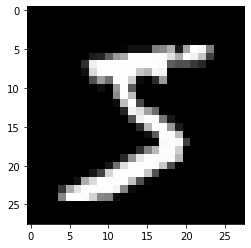

predicted label: 5
true label: 5


In [15]:
from matplotlib import pyplot as plt

image = (train_images[0] + 1.0) * 127.5
image = image.reshape(28, 28).astype(np.uint8)

plt.imshow(image, plt.cm.gray)
plt.show()

predicted_label = np.argmax(model.predict(np.array([train_images[0]]))[0])
true_label = np.argmax(train_labels[0])

print(f'predicted label: {predicted_label}')
print(f'true label: {true_label}')